# PK Currency Classification

## Importing Libraries

In [ ]:
import zipfile
import tensorflow as tf
import random
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import numpy as np

## Downloading and extracting the dataset

In [1]:
#upload your kaggle json file to download dataset
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rafayqayyum/pakistan-image-currency-dataset

 97% 543M/557M [00:04<00:00, 142MB/s]
100% 557M/557M [00:04<00:00, 138MB/s]


In [2]:
zp=zipfile.ZipFile('/content/pakistan-image-currency-dataset.zip')
zp.extractall()
zp.close()

## Downloading and extracting the dataset

## Loading the dataset

In [3]:
data_dir='/content/currencyDataset'
img_height=224
img_width=224
batch_size=16
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  validation_split=0.15,
  subset='training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3891 files belonging to 15 classes.
Using 3308 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  validation_split=0.15,
  subset='validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 3891 files belonging to 15 classes.
Using 583 files for validation.


## Visualizing and extracting information from dataset

In [5]:
class_names=train_ds.class_names
num_classes=len(class_names)

In [6]:
num_classes,class_names

(15,
 ['1000_back',
  '1000_front',
  '100_back',
  '100_front',
  '10_back',
  '10_front',
  '20_back',
  '20_front',
  '5000_back',
  '5000_front',
  '500_back',
  '500_front',
  '50_back',
  '50_front',
  'others'])

In [7]:
joblib.dump(class_names,"classnames.dump")

['classnames.dump']

In [8]:
class_names

['1000_back',
 '1000_front',
 '100_back',
 '100_front',
 '10_back',
 '10_front',
 '20_back',
 '20_front',
 '5000_back',
 '5000_front',
 '500_back',
 '500_front',
 '50_back',
 '50_front',
 'others']

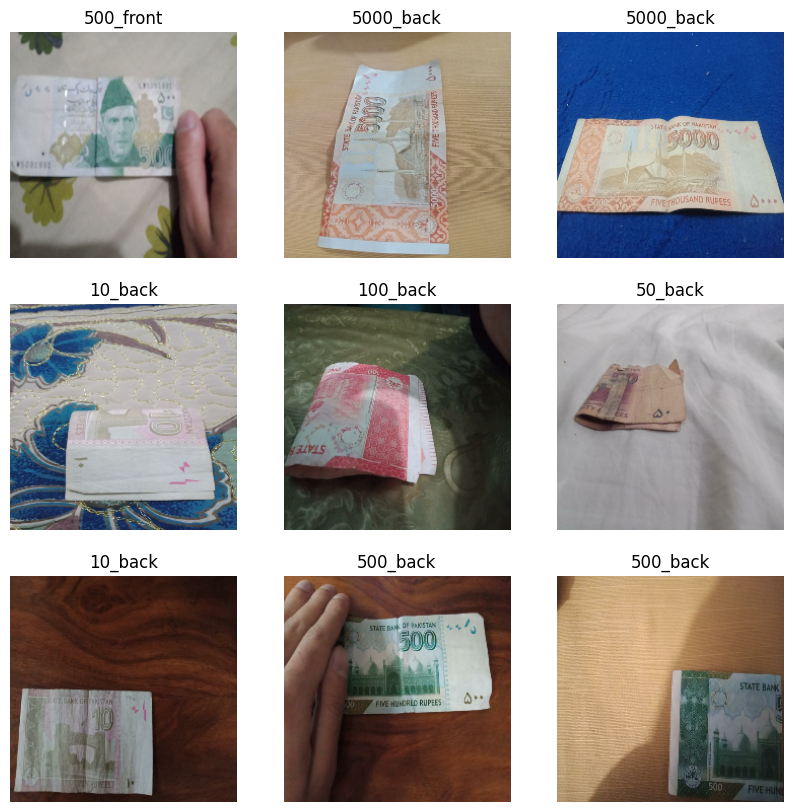

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

In [10]:
for image,label in train_ds.take(1):
  print(f"""
  Image shape: {image[0].shape},
  Image datatype: {image[0].dtype},
  Target class from (tensor form) :{label[0]},
  Class name (str form): {class_names[tf.argmax(label[0])]}
  """)



  Image shape: (224, 224, 3),
  Image datatype: <dtype: 'float32'>,
  Target class from (tensor form) :[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],
  Class name (str form): 100_front
  


In [11]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [12]:
len(train_ds)

207

In [14]:
train_data=train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

val_data=val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Modelling

### Model: EfficientNetV2B0

In [15]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [16]:
input_shape = (img_width, img_height, 3)

base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",
                                                  input_shape=input_shape, pooling='max')
base_model.trainable=True


inputs = tf.keras.layers.Input(shape=input_shape)

x = data_augmentation(inputs)
x=base_model(x)

x= tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer= tf.keras.regularizers.l1(0.006),
                bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=.4, seed=123)(x)

output=tf.keras.layers.Dense(num_classes, activation='softmax')(x)


model=tf.keras.Model(inputs=inputs, outputs=output)

24274472/24274472 [==============================] - 0s 0us/step


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [18]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [19]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [20]:
history = model.fit(train_data,
                    epochs=15,
                    validation_data=val_data,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/15
207/207 [==============================] - 85s 165ms/step - loss: 9.8513 - accuracy: 0.2615 - val_loss: 8.4286 - val_accuracy: 0.6432 - lr: 1.0000e-04
Epoch 2/15
207/207 [==============================] - 33s 155ms/step - loss: 7.7550 - accuracy: 0.7152 - val_loss: 7.0440 - val_accuracy: 0.8885 - lr: 1.0000e-04
Epoch 3/15
207/207 [==============================] - 31s 149ms/step - loss: 6.6730 - accuracy: 0.8863 - val_loss: 6.2149 - val_accuracy: 0.9383 - lr: 1.0000e-04
Epoch 4/15
207/207 [==============================] - 33s 157ms/step - loss: 5.8676 - accuracy: 0.9368 - val_loss: 5.4710 - val_accuracy: 0.9503 - lr: 1.0000e-04
Epoch 5/15
207/207 [==============================] - 32s 150ms/step - loss: 5.1520 - accuracy: 0.9489 - val_loss: 4.7495 - val_accuracy: 0.9743 - lr: 1.0000e-04
Epoch 6/15
207/207 [==============================] - 32s 153ms/step - loss: 4.4590 - accuracy: 0.9652 - val_loss: 4.0873 - val_accuracy: 0.9846 - lr: 1.0000e-04
Epoch 7/15
207/207 [========

In [21]:
model.evaluate(val_data)

37/37 [==============================] - 3s 64ms/step - loss: 0.7787 - accuracy: 0.9983


[0.7787347435951233, 0.9982847571372986]

In [22]:
model.save('currency_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
def get_labels_preds(mod,data):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in data:
    y_true.append(np.argmax(label_batch, axis=-1))
    preds = mod.predict(image_batch)
    y_pred.append(np.argmax(preds, axis =-1))

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)
  return correct_labels, predicted_labels

In [36]:
correct_labels, predicted_labels = get_labels_preds(model,val_data)

1/1 [==============================] - 0s 28ms/step


### Evaluation

#### Classification report and Confusion Matrix

In [38]:
predicted_labels[0]

<tf.Tensor: shape=(), dtype=int64, numpy=12>

In [39]:
correct_labels[0]

<tf.Tensor: shape=(), dtype=int64, numpy=12>

In [40]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      0.97      0.99        37
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        39
           4       1.00      1.00      1.00        38
           5       1.00      1.00      1.00        46
           6       1.00      1.00      1.00        32
           7       1.00      1.00      1.00        38
           8       1.00      1.00      1.00        27
           9       1.00      1.00      1.00        51
          10       1.00      1.00      1.00        47
          11       1.00      1.00      1.00        42
          12       1.00      1.00      1.00        46
          13       1.00      1.00      1.00        38
          14       0.97      1.00      0.98        31

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00   

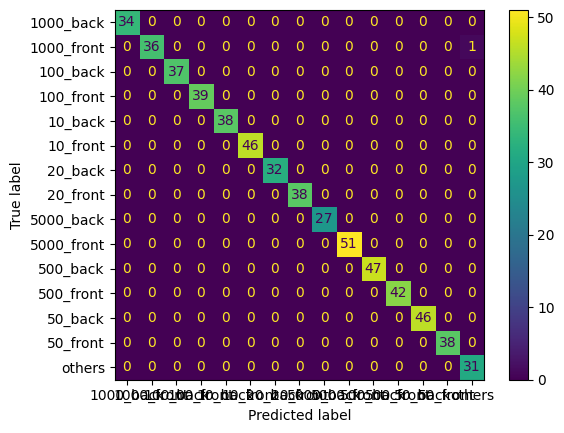

In [43]:
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,y_pred=predicted_labels,display_labels=class_names);

#### Plotting F1-scores

In [44]:
classification_report_dict=classification_report(correct_labels,predicted_labels,output_dict=True)

In [45]:
f1_scores={}
for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    #add class names and f1_scores to new dict
    f1_scores[class_names[int(k)]]=v['f1-score']

In [47]:
#turn f1-score to dataframe
f1_scores_df=pd.DataFrame({'class_names':list(f1_scores.keys()),
                           'f1-score':list(f1_scores.values())}).sort_values('f1-score',ascending=False)

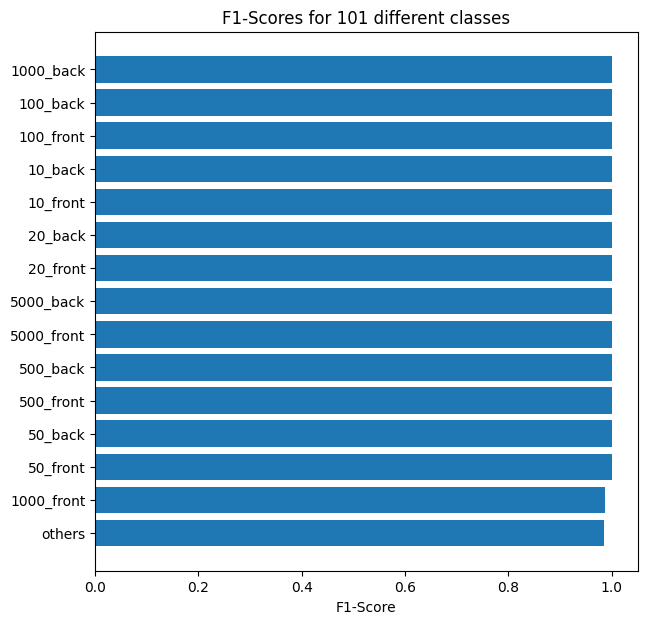

In [48]:
fig,ax=plt.subplots(figsize=(7,7))
#creates bar chart
scores=ax.barh(range(len(f1_scores_df)),f1_scores_df['f1-score'].values)
#sets no of ticks
ax.set_yticks(range(len(f1_scores_df)))
#sets labels for ticks
a=ax.set_yticklabels(f1_scores_df['class_names'])

ax.set_xlabel('F1-Score')
ax.set_title('F1-Scores for 101 different classes')
#invert the ais
ax.invert_yaxis()

#### Visualizing Random images from the dataset

1/1 [==============================] - 0s 26ms/step


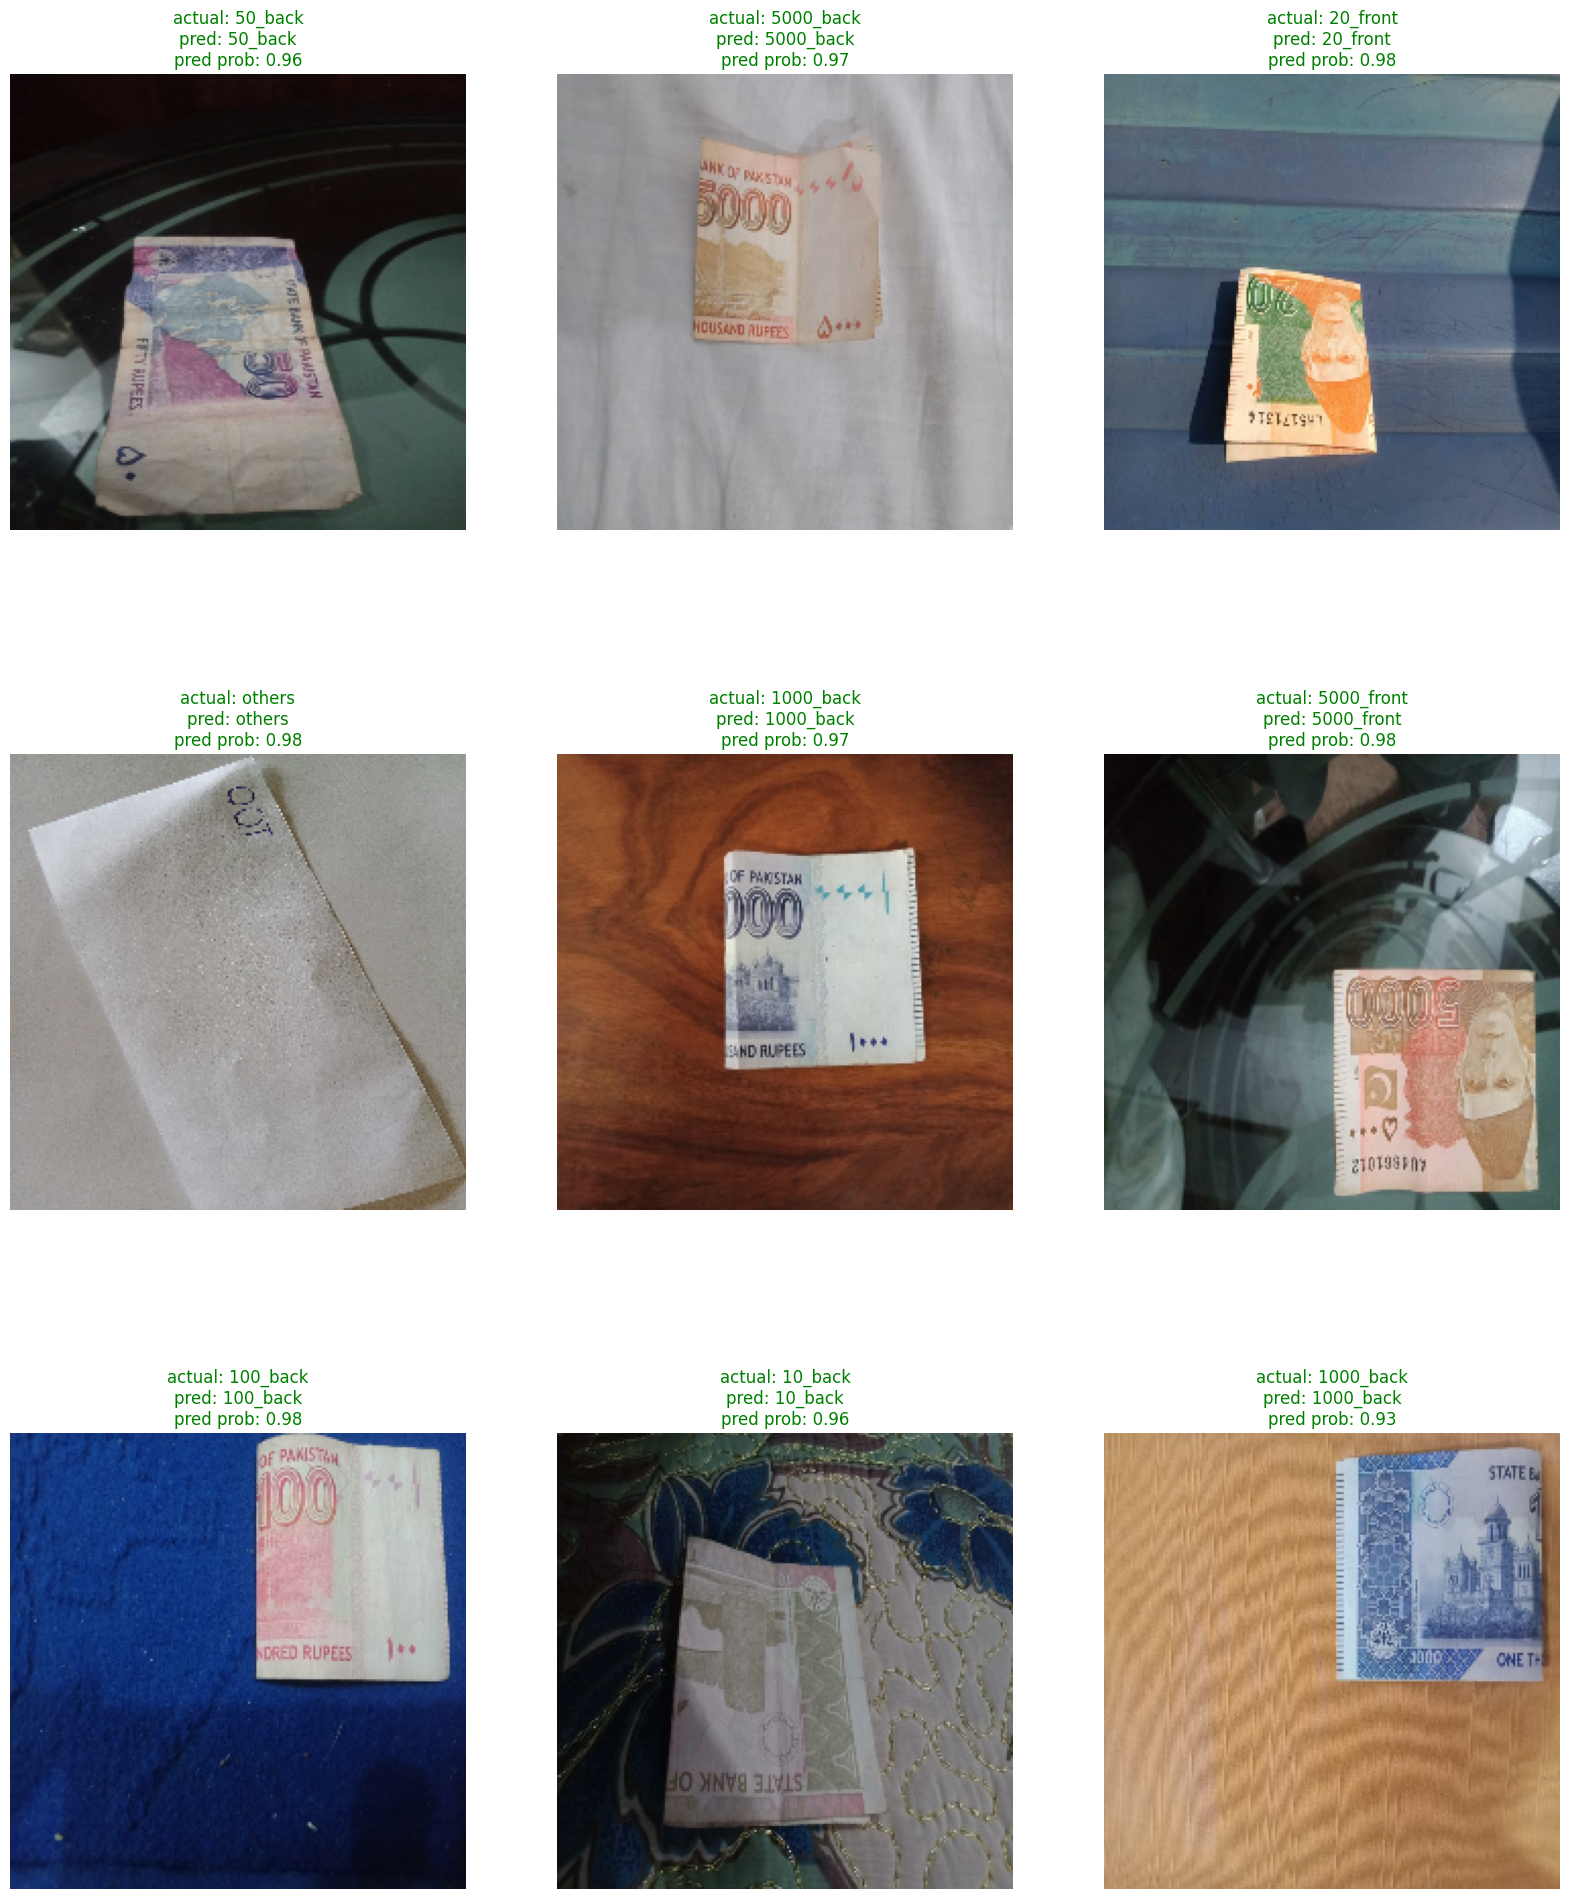

In [60]:
def plot_samples(mod, data):
  plt.figure(figsize=(20,25))
  random_choices=random.sample(range(0, 15), 9)
  for img,label in data.take(1):
    for j,i in enumerate(random_choices):

      pred_prob=mod.predict(tf.expand_dims(img[i],axis=0))
      pred_class=class_names[pred_prob.argmax()]
      class_name=class_names[tf.argmax(label[i], axis=-1)]

      #plot image
      plt.subplot(3,3,j+1)
      plt.imshow(img[i]/255.)  #matplotlib needs normalized images
      if class_name==pred_class:
        title_color='g'
      else:
        title_color='r'
      plt.title(f'actual: {class_name}\npred: {pred_class}\npred prob: {pred_prob.max():.2f}',c=title_color)
      plt.axis(False)

plot_samples(model, val_data)

### Model: MobileNet

In [61]:
input_shape = (img_width, img_height, 3)

base_model=tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet",
                                                   input_shape=input_shape, pooling='max')
base_model.trainable=True
inputs = tf.keras.layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x=base_model(x)
x= tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer= tf.keras.regularizers.l1(0.006),
                bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=.4, seed=123)(x)
output=tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model2=tf.keras.Model(inputs=inputs, outputs=output)

4334752/4334752 [==============================] - 0s 0us/step


In [62]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_1 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               147712    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0   

In [63]:
model2.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [64]:
# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [65]:
history = model2.fit(train_data,
                    epochs=15,
                    validation_data=val_data,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/15
207/207 [==============================] - 51s 125ms/step - loss: 8.9768 - accuracy: 0.1675 - val_loss: 7.9477 - val_accuracy: 0.3619 - lr: 1.0000e-04
Epoch 2/15
207/207 [==============================] - 24s 112ms/step - loss: 7.3113 - accuracy: 0.4946 - val_loss: 6.6352 - val_accuracy: 0.6775 - lr: 1.0000e-04
Epoch 3/15
207/207 [==============================] - 24s 112ms/step - loss: 6.2569 - accuracy: 0.7225 - val_loss: 5.7609 - val_accuracy: 0.8439 - lr: 1.0000e-04
Epoch 4/15
207/207 [==============================] - 26s 121ms/step - loss: 5.5168 - accuracy: 0.8304 - val_loss: 5.0956 - val_accuracy: 0.9108 - lr: 1.0000e-04
Epoch 5/15
207/207 [==============================] - 24s 114ms/step - loss: 4.9062 - accuracy: 0.8900 - val_loss: 4.5478 - val_accuracy: 0.9245 - lr: 1.0000e-04
Epoch 6/15
207/207 [==============================] - 25s 119ms/step - loss: 4.3691 - accuracy: 0.9205 - val_loss: 4.0276 - val_accuracy: 0.9554 - lr: 1.0000e-04
Epoch 7/15
207/207 [========

### Evaluation

In [66]:
model2.evaluate(val_data)

37/37 [==============================] - 2s 53ms/step - loss: 1.1172 - accuracy: 0.9931


[1.1172393560409546, 0.9931389093399048]

In [68]:
model2.save('currency_model_mobilenet.h5')

#### Classification report and Confusion Matrix

In [72]:
correct_labels, predicted_labels = get_labels_preds(model2,val_data)

1/1 [==============================] - 0s 25ms/step


In [73]:
predicted_labels[0]

<tf.Tensor: shape=(), dtype=int64, numpy=5>

In [74]:
correct_labels[0]

<tf.Tensor: shape=(), dtype=int64, numpy=5>

In [75]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.97      1.00      0.99        37
           2       0.97      1.00      0.99        37
           3       1.00      0.97      0.99        39
           4       1.00      0.97      0.99        38
           5       0.98      1.00      0.99        46
           6       1.00      1.00      1.00        32
           7       1.00      1.00      1.00        38
           8       1.00      1.00      1.00        27
           9       1.00      1.00      1.00        51
          10       1.00      0.98      0.99        47
          11       0.98      1.00      0.99        42
          12       1.00      1.00      1.00        46
          13       1.00      0.97      0.99        38
          14       1.00      1.00      1.00        31

    accuracy                           0.99       583
   macro avg       0.99      0.99      0.99       583
weighted avg       0.99   

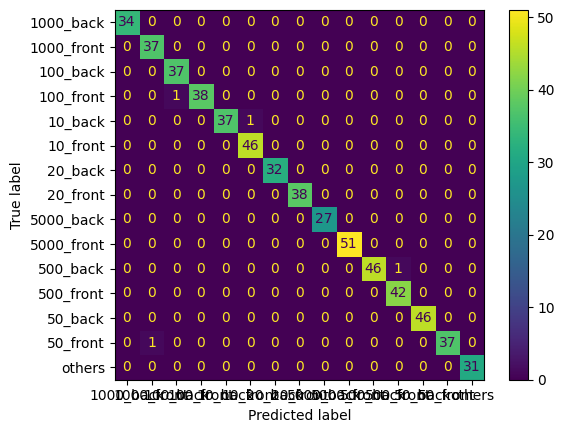

In [76]:
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,y_pred=predicted_labels,display_labels=class_names);

#### Plotting F1-scores

In [77]:
classification_report_dict=classification_report(correct_labels,predicted_labels,output_dict=True)

In [78]:
f1_scores={}
for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    #add class names and f1_scores to new dict
    f1_scores[class_names[int(k)]]=v['f1-score']

In [79]:
#turn f1-score to dataframe
f1_scores_df=pd.DataFrame({'class_names':list(f1_scores.keys()),
                           'f1-score':list(f1_scores.values())}).sort_values('f1-score',ascending=False)

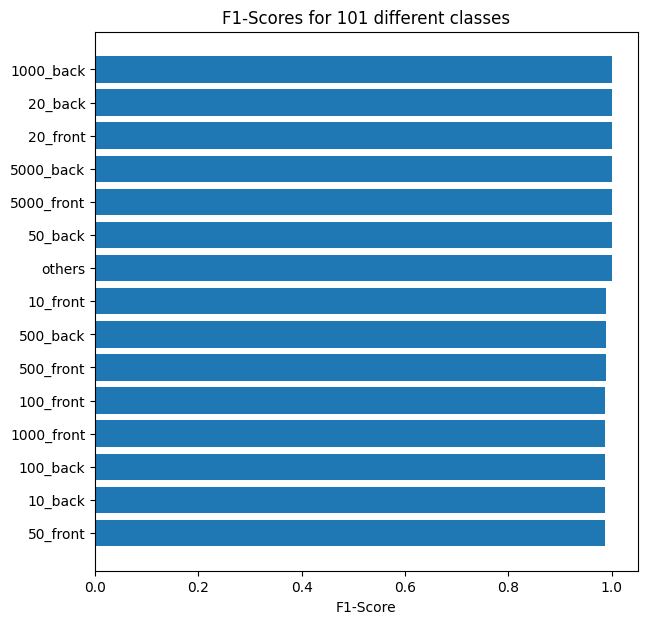

In [80]:
fig,ax=plt.subplots(figsize=(7,7))
#creates bar chart
scores=ax.barh(range(len(f1_scores_df)),f1_scores_df['f1-score'].values)
#sets no of ticks
ax.set_yticks(range(len(f1_scores_df)))
#sets labels for ticks
a=ax.set_yticklabels(f1_scores_df['class_names'])

ax.set_xlabel('F1-Score')
ax.set_title('F1-Scores for 101 different classes')
#invert the ais
ax.invert_yaxis()

#### Visualizing Random images from the dataset

1/1 [==============================] - 0s 26ms/step


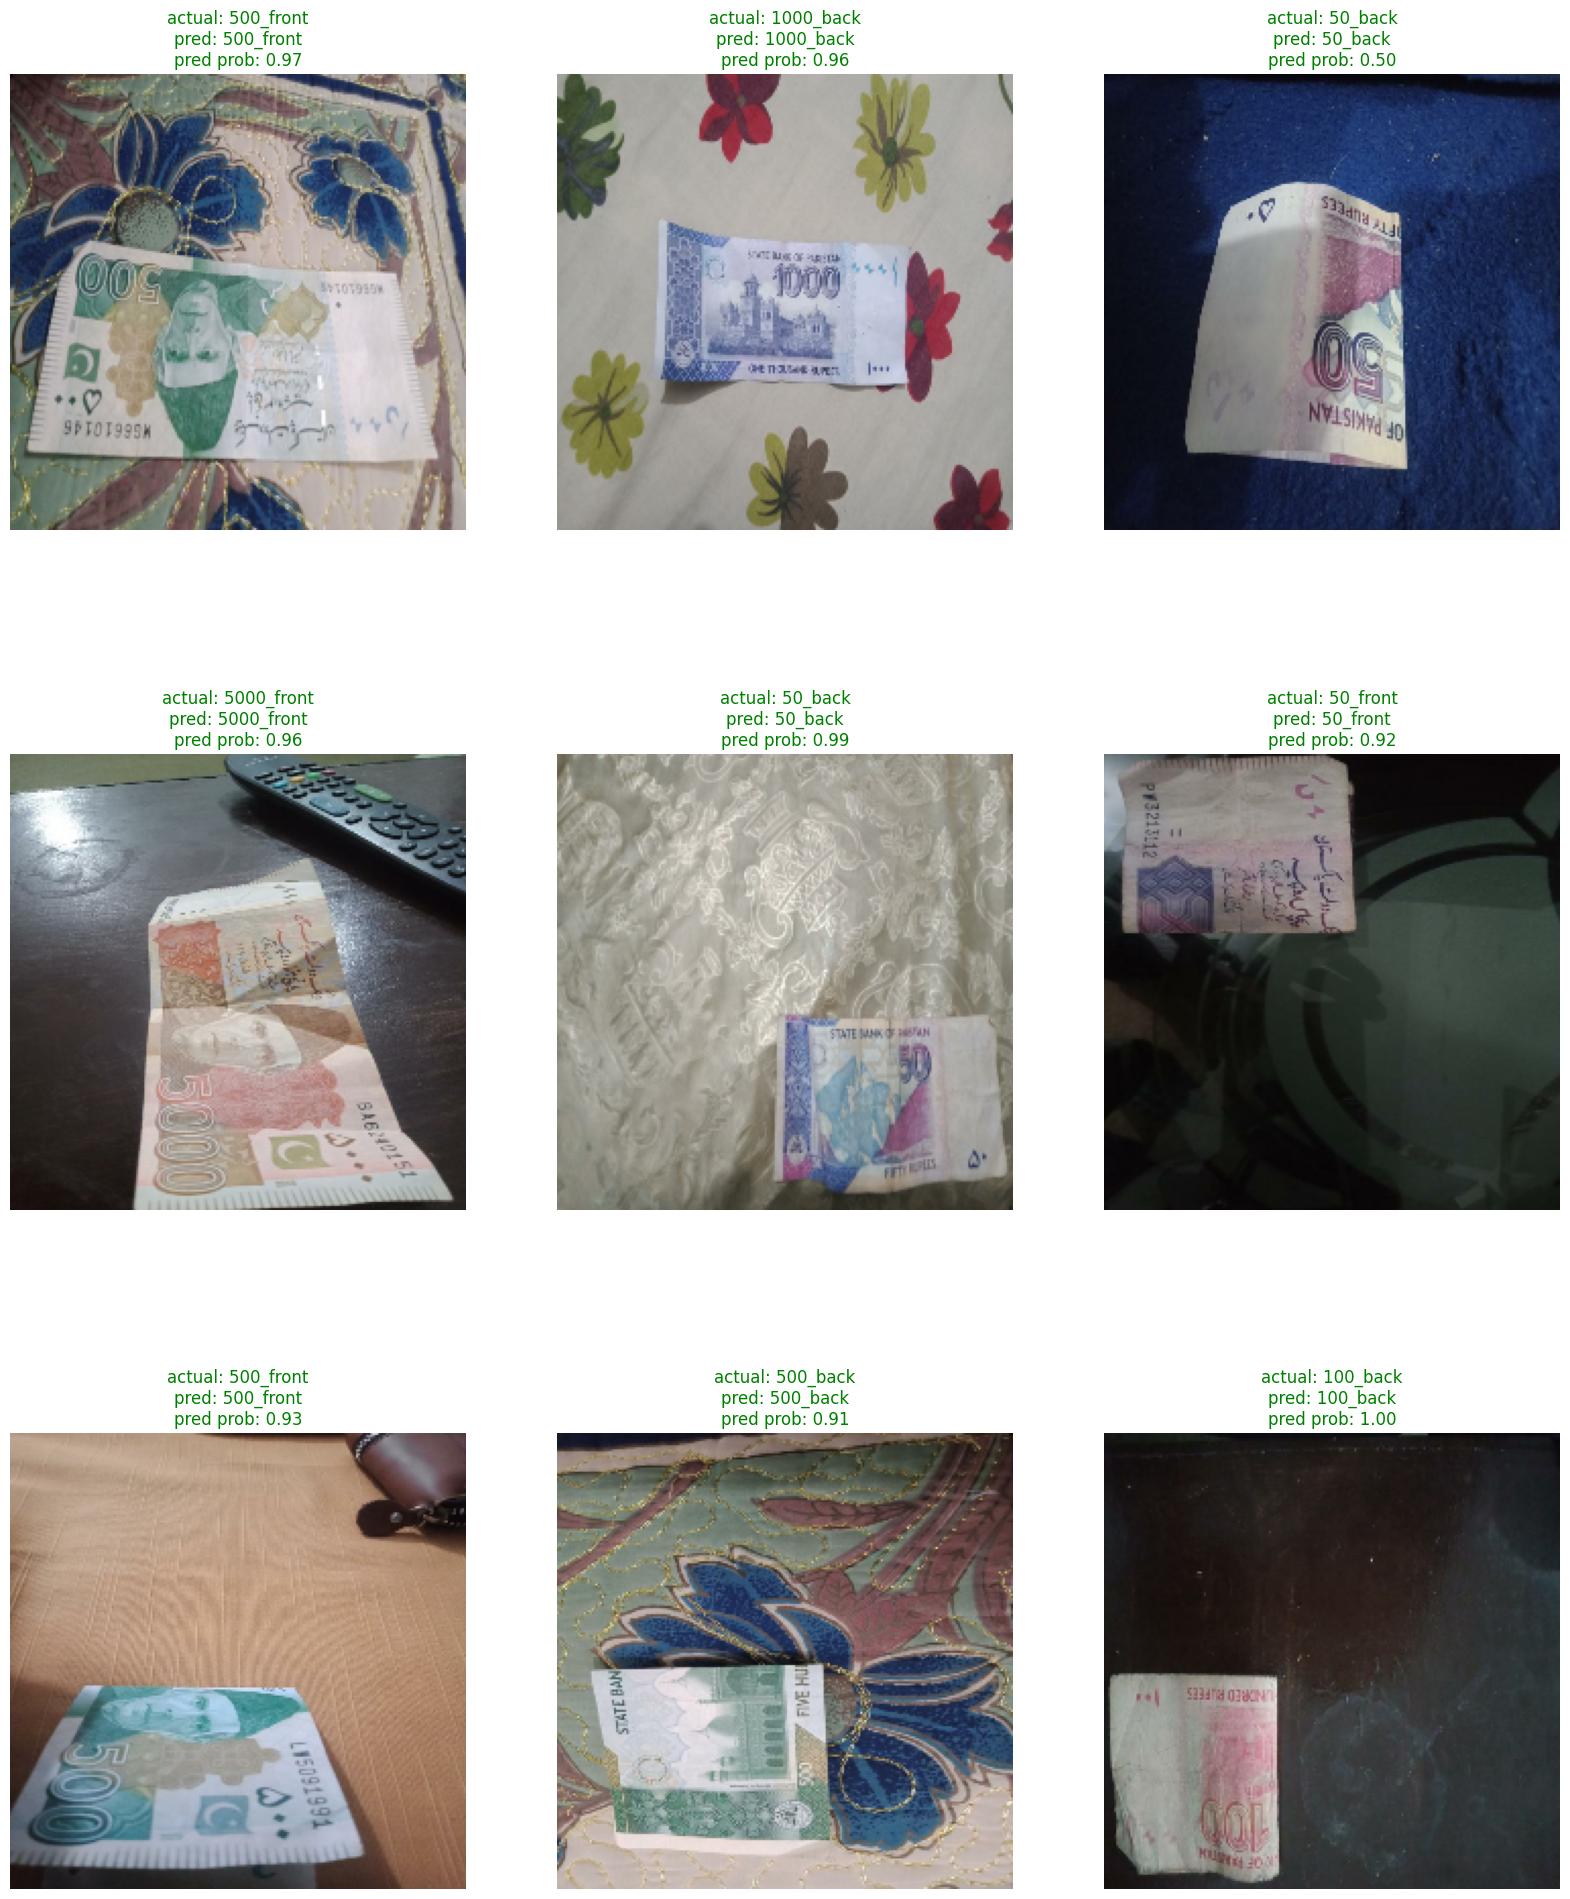

In [81]:
plot_samples(model, val_data)